# Build a training dataset for ML-based $\Delta$FAC
The training dataset needs columns of the following (where each row represents one example):
1. 91 day $\Delta$FAC (m)
2. 91 day average precipitation (mm/day)
3. 1980 - 2021 precipitation climatology (mm/day)
4. 91 day average temperature (C)
5. 1980 - 2021 temperature climatology (C)
6. (10 day precip before tf) - (10 day precip before t0) (mm)

In [5]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Settings

In [6]:
# meteo_smet = "/scratch/summit/erke2265/mass-balance/1_site/smet/-71.000_136.875.smet"
# snowpack_smet = "/scratch/summit/erke2265/mass-balance/1_site/output/-71.000_136.875_SPINUP.smet"
meteo_smet = "/scratch/summit/erke2265/mass-balance/10_sites/smet/-66.500_87.500.smet"
snowpack_smet = "/scratch/summit/erke2265/mass-balance/10_sites/output/-66.500_87.500_SPINUP.smet"

# Functions

In [7]:
def read_smet(path, var):

    """ Reads a .smet file and returns a time series of the defined variable as a pandas data frame.
    Args:
        path (str): String pointing to the location of the .smet file to be read.
        var  (str): Variable you want to plot
    Returns:
        Time series of defined variable as a pandas data frame.
    """

    # Load .smet file as a Pandas data frame
    df = pd.read_csv(path)

    # Determine indices for data retrieval
    bump = 2

    fields_row = np.where(df[df.columns[0]].str.startswith("fields"))[0][0] + bump
    data_row = np.where(df[df.columns[0]] == '[DATA]')[0][0] + bump
    fields =  np.loadtxt(path, skiprows=fields_row - 1, max_rows=1, dtype='str')
    data_col = np.where(fields == var)[0][0] - bump

    # Creates pandas data frame
    time = np.loadtxt(path, skiprows=data_row, usecols=0, dtype = 'str')
    time = pd.to_datetime(time, format='%Y-%m-%dT%H:%M:%S')
    data = np.loadtxt(path, skiprows=data_row, usecols=data_col)
    ts = pd.DataFrame(data, index=time)

    # Set no data values to nan
    ts[ts == -999] = np.nan

    # Return time series as daily average Pandas data frame
    return ts

def calc_FAC(HS, SWE):
    
    """
    SNOWPACK assumes the density of ice is 917 kg/m^3
    """
    
    SWE_in_units_ice_equivalent = SWE / 0.917
    FAC = HS - SWE_in_units_ice_equivalent
    return FAC

# Temperature

In [8]:
ta = read_smet(meteo_smet, "TA")
ta = ta.resample('D').mean()
ta_mean = ta.mean() # Use in traning
ta_91_day_mean = ta.rolling(91).mean() # Use in traning

0    260.672603
dtype: float64


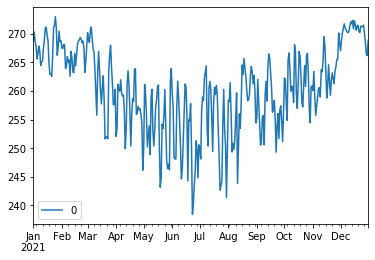

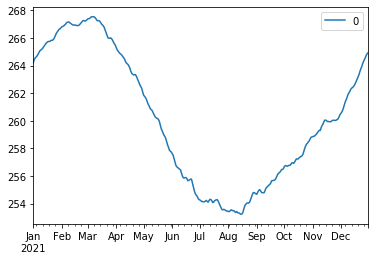

In [9]:
ta[-365:].plot()
ta_91_day_mean[-365:].plot()
print(ta_mean)

# Precipitation

In [10]:
psum = read_smet(meteo_smet, "PSUM")
psum = psum.resample('D').sum()
psum_mean = psum.mean() # Use in traning
psum_91_day_mean = psum.rolling(91).mean() # Use in traning

0    1.89214
dtype: float64


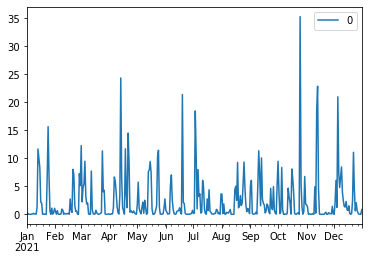

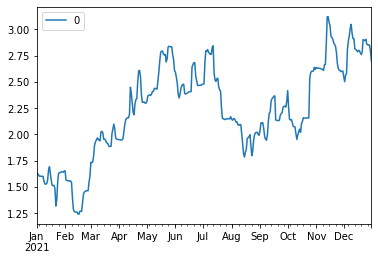

In [11]:
psum[-365:].plot()
psum_91_day_mean[-365:].plot()
print(psum_mean)

# 10 day precip

In [12]:
precip_10_day_mean = psum.rolling(10).mean()
precip_10_day_mean_diff = precip_10_day_mean.diff(periods=91) # Use in traning

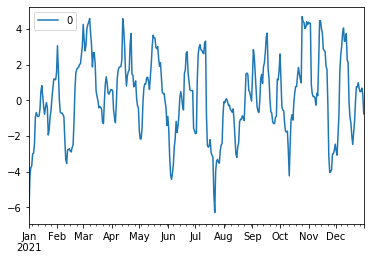

In [13]:
precip_10_day_mean_diff[-365:].plot()

# $\Delta$FAC

In [14]:
HS = read_smet(snowpack_smet, "HS_mod") / 100 # Units: m
SWE = read_smet(snowpack_smet, "SWE") / 1000 # Units: m

HS = HS.resample('D').mean()
SWE = SWE.resample('D').mean()

FAC = calc_FAC(HS, SWE)
delta_FAC_91_day = FAC.diff(periods=91) # Use in traning

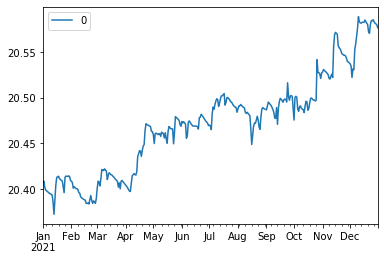

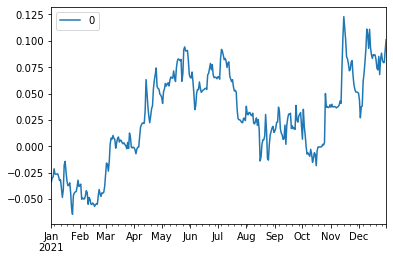

In [15]:
FAC[-365:].plot()
delta_FAC_91_day[-365:].plot()

# Compile into training dataset which has been randomly shuffled
Build a daily dataset from 1980 - 2021 (42 years)

In [16]:
# Index corresponding to the first day of 2000 (hacky... sorry)
# ind_1980 = -365 * 42 + 80 # Before using x5
ind_1980 = -365 * 42 + 89 # After using x5


# Target data
Y = np.squeeze(delta_FAC_91_day[ind_1980:].values)

# Features
x1 = np.squeeze(psum_91_day_mean[ind_1980:].values)
x2 = np.repeat(psum_mean.values, len(x1))
x3 = np.squeeze(ta_91_day_mean[ind_1980:].values)
x4 = np.repeat(ta_mean.values, len(x1))
x5 = np.squeeze(precip_10_day_mean_diff[ind_1980:].values)

In [17]:
train = np.transpose(np.stack([Y, x1, x2, x3, x4, x5]))
np.random.shuffle(train)
print(train.shape)
np.savetxt("train.txt", train)

(15241, 6)
